In [55]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator

In [3]:
def load_cv_results(models, base_dir, year=2017, trials=5, ext='', fluxes=False):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    radar_idx = dict()
    
    for i, (m, d) in enumerate(models.items()):

        # load predictions
        model_dir = osp.join(base_dir, m)
        result_list = []
        radar_idx_list = []
        for t in range(1, trials+1):
            file = osp.join(model_dir, f'test_{year}', d, f'trial_{t}', f'results{ext}.csv')
            if osp.isfile(file):
                df = pd.read_csv(file)
                df['trial'] = t
                result_list.append(df)
            
            radar_path = osp.join(osp.dirname(file), 'radar_index.pickle')
            if osp.isfile(radar_path):
                with open(radar_path, 'rb') as f:
                    radar_idx_list.append(pickle.load(f))
        radar_idx[m] = radar_idx_list
        results[m] = pd.concat(result_list)
        
        print(f'successfully loaded results for {m}')
        
        # load fluxes
        if fluxes and 'Flux' in m:
            m_fluxes = [dict(), dict()]
            for t in range(1, trials+1):
                sub_dir = osp.join(model_dir, f'test_{year}', d, f'trial_{t}')
                          
                with open(osp.join(sub_dir, f'radar_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[0][t] = pickle.load(f)
                          
                with open(osp.join(sub_dir, f'model_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[1][t] = pickle.load(f)
    
            all_fluxes[m] = m_fluxes

    return results, bird_scales, all_fluxes, radar_idx

In [4]:
def compute_rmse(m, results, groupby='fold', threshold=0, km2=True):
    
    ext = '_km2' if km2 else ''
        
    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}')
    rmse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    rmse = rmse.reset_index(name='rmse')
    rmse['model'] = m
    
    return rmse

In [128]:
def plot_fluxes(voronoi, G, all_fluxes, results, model=1, context=24, horizon=64, bird_scale=1, 
                net_fluxes=False, abm=False, ax=None, crs=None, max_flux=0, cbar=True):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

#     if abm:
#         f = np.concatenate([f[..., :horizon+1] for f in all_fluxes.values()], axis=-1)
#         mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
#                            for i in range(len(all_fluxes))])
#     else:
    if model:
        f = torch.cat([f for f in all_fluxes.values()], dim=-1).detach().numpy()
    else:
        f = np.concatenate([f[..., context:context+horizon] for f in all_fluxes.values()], axis=-1)
#     mask = np.concatenate([results.query(f'seqID == {i} & horizon > {context}').groupby('horizon').night.all().values 
#                        for i in range(len(all_fluxes))])


    #radars = results.radar.unique()
    radars = voronoi.radar.values

    #f[f == 0] = np.nan
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i]) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j])
#             print(val, val2)
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0 and i !=j :
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    fluxes *= bird_scale
    edge_widths = np.minimum(fluxes, max_flux) / (0.25 * max_flux) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    
    #max_flux = max(max_flux, fluxes.max())
    norm = plt.Normalize(0, max_flux)
    #print(fluxes.min(), fluxes.max())
    #print(nx.get_edge_attributes(G_new, 'flux'))
    edge_colors = cmap(norm(fluxes))

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=9000/len(G_new), node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)

    if cbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, label='number of birds', extend='max');
    return G_new, ax, max_flux

In [127]:
a = np.random.rand(5)
np.minimum(a, 0.5)

array([0.5       , 0.27957943, 0.5       , 0.5       , 0.5       ])

In [6]:

def compute_mse(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    #results[f'squared_error{ext}'] = (results[f'gt{ext}'].apply(lambda x: np.log(x + 0.001)) - results[f'prediction{ext}'].apply(lambda x: np.log(x + 0.001))).pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}') # & night == 1')
    mse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean) #.apply(np.sqrt)
    mse = mse.reset_index(name='rmse')
    mse['model'] = model
    mse['experiment'] = experiment

    return mse

def compute_pcc(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0 & gt{ext} >= {threshold}').dropna() # & night == 1')
    pcc = df.groupby(groupby)[['gt_km2', 'prediction_km2']].corr().iloc[0::2,-1]
    pcc = pcc.reset_index()
    pcc['model'] = model
    pcc['experiment'] = experiment

    return pcc

def compute_classification(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0').dropna()
    df['tp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] > threshold)
    df['fp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] < threshold)
    df['fn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] > threshold)
    df['tn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] < threshold)

    gr = df.groupby(groupby).aggregate(sum).reset_index()
    gr['accuracy'] = (gr.tp + gr.tn) / (gr.tp + gr.fp + gr.tn + gr.fn)
    gr['precision'] = gr.tp / (gr.tp + gr.fp)
    gr['sensitivity'] = gr.tp / (gr.tp + gr.fn)
    gr['specificity'] = gr.tn / (gr.tn + gr.fp)
    gr['fscore'] = 2 / ((1 / gr.precision) + (1 / gr.sensitivity))
    
    gr = gr.reset_index()
    gr['model'] = model
    gr['experiment'] = experiment

    return gr


In [7]:
base_dir = '/home/fiona/birdMigration/results/abm'
#base_dir = '/media/fiona/Seagate Basic/PhD/paper_1/results/abm'

In [7]:
models = ['GAM', 'LocalMLP', 'LocalLSTM', 'FluxGraphLSTM']
ext = '_fixedT0'
all_rmse = []
all_rmse_per_h = []
for m in models:
    all_rmse.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_fold_thr0{ext}.csv')))
    all_rmse_per_h.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_hour_thr0{ext}.csv')))
df_rmse = pd.concat(all_rmse)
df_rmse_h = pd.concat(all_rmse_per_h)

In [61]:
models = {'GAM': 'final_evaluation'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='', fluxes=False, trials=1)

/home/fiona/birdMigration/results/abm/GAM/test_2017/final_evaluation/trial_1/results.csv
successfully loaded results for GAM


In [113]:
models = {'FluxGraphLSTM': 'test_new_weight_func_split_delta'}
r, _, fluxes, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=True, trials=1)

successfully loaded results for FluxGraphLSTM


In [41]:
models = {'FluxGraphLSTM': 'final_evaluation_lr'}
r, _, fluxes, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=True, trials=1)

successfully loaded results for FluxGraphLSTM


In [31]:
models = {'GAM': 'final_evaluation', 'GBT': 'final_evaluation', 'LocalMLP': 'final_evaluation_importance_sampling', 'LocalLSTM': 'final_evaluation', 'FluxGraphLSTM': 'final_evaluation_lr'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=False, trials=5)

successfully loaded results for GAM
successfully loaded results for GBT
successfully loaded results for LocalMLP
successfully loaded results for LocalLSTM
successfully loaded results for FluxGraphLSTM


In [32]:
all_mse = []
all_pcc = []
all_bin = []
for m, d in models.items():
    all_mse.append(compute_mse(m, d, r[m], groupby=['horizon', 'radar', 'trial'], threshold=0, km2=True))
    all_pcc.append(compute_pcc(m, d, r[m], groupby=['horizon', 'trial'], threshold=0, km2=True))
    all_bin.append(compute_classification(m, d, r[m], groupby=['horizon', 'trial'], threshold=0.01, km2=True))
df_mse = pd.concat(all_mse)
df_pcc = pd.concat(all_pcc)
df_bin = pd.concat(all_bin)

In [181]:
models = {'HA': 'final_evaluation_new',
          'GAM': 'final_evaluation_new',
          'GBT': 'final_evaluation_new_importance_sampling_acc',
          'LocalLSTM': 'final_evaluation',
          'FluxGraphLSTM': 'test_new_weight_func_split_delta'
         }
ext = ''
thr = 5
mse, pcc, clf = [], [], []
for m, d in models.items():
    mse.append(pd.read_csv(osp.join(base_dir, m, 'test_2017', d, 'performance_evaluation', f'mse_per_hour{ext}.csv')))
    pcc.append(pd.read_csv(osp.join(base_dir, m, 'test_2017', d, 'performance_evaluation', f'pcc_per_hour{ext}.csv')))
    clf.append(pd.read_csv(osp.join(base_dir, m, 'test_2017', d, 'performance_evaluation', f'bin_per_hour_thr{thr}{ext}.csv')))
mse = pd.concat(mse)
pcc = pd.concat(pcc)
clf = pd.concat(clf)

mse['rmse'] = mse['mse'].apply(np.sqrt)

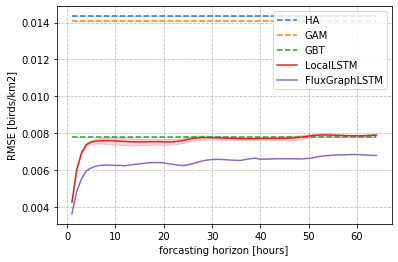

In [172]:
horizon = 64
static_models = ['HA', 'GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(6,4))

#for group, df in mse.groupby(['model', 'experiment']): 
for m, e in models.items():
    df = mse.query(f'model == "{m}" & experiment == "{e}"')
    if m in static_models:
        if m == 'GBT':
            df = df.query('trial != 1')
        grouped = df.groupby('trial')
        df = grouped.aggregate(np.nanmean).reset_index()
        rmse = df.mse.apply(np.sqrt).to_numpy()
        line = ax.plot(range(1,horizon+1), [np.nanmean(rmse)]*horizon, label=m, ls='--')
        ax.fill_between(range(1, horizon+1), [np.nanmean(rmse)-np.nanstd(rmse)]*horizon, [np.nanmean(rmse)+np.nanstd(rmse)]*horizon, color=line[0].get_color(), alpha=0.2)
    else:
        grouped = df.groupby('horizon')
        avg = grouped.rmse.aggregate(np.nanmean).values[-horizon:]
        std = grouped.rmse.aggregate(np.nanstd).values[-horizon:]
        line = ax.plot(range(1, horizon+1), avg, label=m)#, ls='--', marker='o')
        ax.fill_between(range(1, horizon+1), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
        
ax.legend(loc=1)
ax.set(xlabel='forcasting horizon [hours]', ylabel='RMSE [birds/km2]')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);
fig.savefig('/home/fiona/birdMigration/data/plots/final/rmse_per_hour.png', bbox_inches='tight', dpi=200)

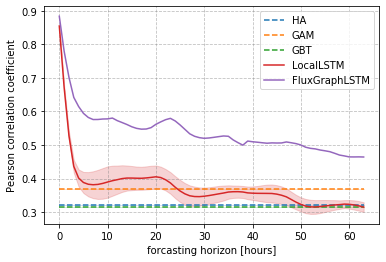

In [173]:
horizon = 64
static_models = ['HA', 'GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(6,4))
for m, e in models.items():
    df = pcc.query(f'model == "{m}" & experiment == "{e}"')
    if m in static_models:
        if m == 'GBT':
            df = df.query('trial != 1')
        grouped = df.groupby('trial')
        df = grouped.aggregate(np.nanmean).reset_index()
        line = ax.plot(range(horizon), [np.nanmean(df.pcc)]*horizon, label=m, ls='--')
        ax.fill_between(range(avg.size), [np.nanmean(df.pcc)-np.nanstd(df.pcc)]*horizon, [np.nanmean(df.pcc)+np.nanstd(df.pcc)]*horizon, color=line[0].get_color(), alpha=0.2)
    else:
        grouped = df.groupby('horizon')
        avg = grouped.pcc.aggregate(np.nanmean).values[-horizon:]
        std = grouped.pcc.aggregate(np.nanstd).values[-horizon:]
        line = ax.plot(range(avg.size), avg, label=m)#, ls='--', marker='o')
        ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend(loc=1)
ax.set(xlabel='forcasting horizon [hours]', ylabel='Pearson correlation coefficient')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);
fig.savefig('/home/fiona/birdMigration/data/plots/final/pcc_per_hour.png', bbox_inches='tight', dpi=200)

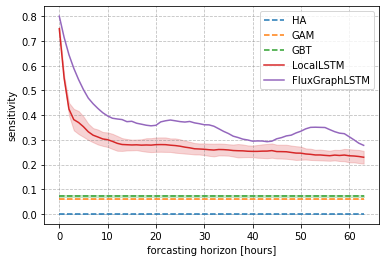

In [182]:
horizon = 64
static_models = ['HA', 'GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(6,4))
for m, e in models.items():
    df = clf.query(f'model == "{m}" & experiment == "{e}"')
    if m in static_models:
        if m == 'GBT':
            df = df.query('trial != 1')
        grouped = df.groupby('trial')
        df = grouped.aggregate(np.nanmean).reset_index()
        line = ax.plot(range(horizon), [np.nanmean(df.sensitivity)]*horizon, label=m, ls='--')
        ax.fill_between(range(avg.size), [np.nanmean(df.sensitivity)-np.nanstd(df.sensitivity)]*horizon, 
                        [np.nanmean(df.sensitivity)+np.nanstd(df.sensitivity)]*horizon, color=line[0].get_color(), alpha=0.2)
    else:
        grouped = df.groupby('horizon')
        avg = grouped.sensitivity.aggregate(np.nanmean).values[-horizon:]
        std = grouped.sensitivity.aggregate(np.nanstd).values[-horizon:]
        line = ax.plot(range(avg.size), avg, label=m)#, ls='--', marker='o')
        ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend(loc=1)
ax.set(xlabel='forcasting horizon [hours]', ylabel='sensitivity')#, title=f'threshold = {thr}% of max migration activity')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);
fig.savefig('/home/fiona/birdMigration/data/plots/final/sensitivity5_per_hour.png', bbox_inches='tight', dpi=200)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/fiona/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


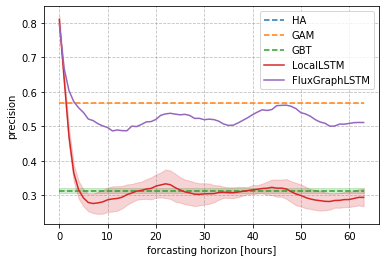

In [183]:
horizon = 64
static_models = ['HA', 'GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(6,4))
for m, e in models.items():
    df = clf.query(f'model == "{m}" & experiment == "{e}"')
    if m in static_models:
        if m == 'GBT':
            df = df.query('trial != 1')
        grouped = df.groupby('trial')
        df = grouped.aggregate(np.nanmean).reset_index()
        line = ax.plot(range(horizon), [np.nanmean(df.precision)]*horizon, label=m, ls='--')
        ax.fill_between(range(avg.size), [np.nanmean(df.precision)-np.nanstd(df.precision)]*horizon, 
                        [np.nanmean(df.precision)+np.nanstd(df.precision)]*horizon, color=line[0].get_color(), alpha=0.2)
    else:
        grouped = df.groupby('horizon')
        avg = grouped.precision.aggregate(np.nanmean).values[-horizon:]
        std = grouped.precision.aggregate(np.nanstd).values[-horizon:]
        line = ax.plot(range(avg.size), avg, label=m)#, ls='--', marker='o')
        ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend(loc=1)
ax.set(xlabel='forcasting horizon [hours]', ylabel='precision')#, title=f'threshold = {thr}% of max migration activity')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);
fig.savefig('/home/fiona/birdMigration/data/plots/final/precision5_per_hour.png', bbox_inches='tight', dpi=200)

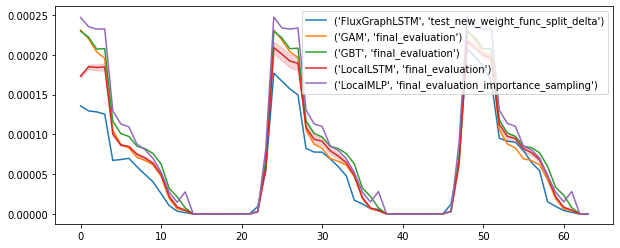

In [11]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_mse.groupby(['model', 'experiment']): 
    grouped = df.groupby(['horizon', 'trial']).rmse.aggregate(np.nanmean).reset_index()
    grouped = grouped.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean).values[-horizon:]
    std = grouped.rmse.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

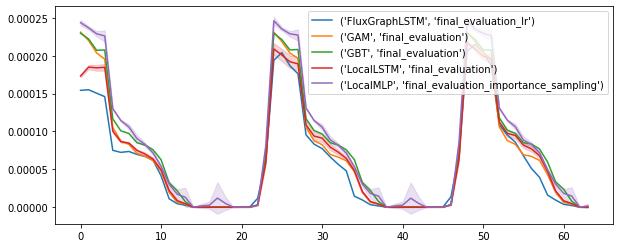

In [33]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_mse.groupby(['model', 'experiment']): 
    grouped = df.groupby(['horizon', 'trial']).rmse.aggregate(np.nanmean).reset_index()
    grouped = grouped.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean).values[-horizon:]
    std = grouped.rmse.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

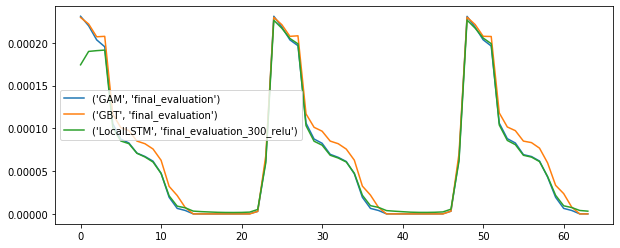

In [331]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_mse.groupby(['model', 'experiment']): 
    grouped = df.groupby(['horizon', 'trial']).rmse.aggregate(np.nanmean).reset_index()
    grouped = grouped.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean).values[-horizon:]
    std = grouped.rmse.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

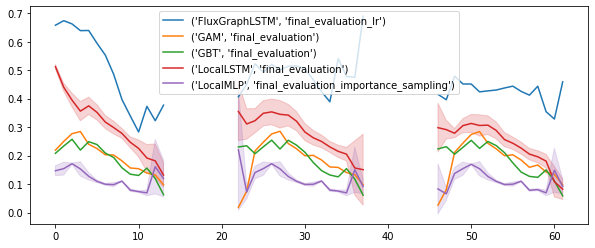

In [34]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_pcc.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped.prediction_km2.aggregate(np.nanmean).values[-horizon:]
    std = grouped.prediction_km2.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

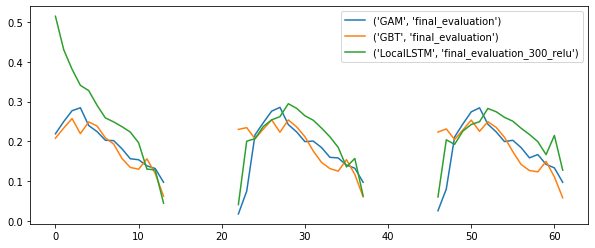

In [332]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_pcc.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped.prediction_km2.aggregate(np.nanmean).values[-horizon:]
    std = grouped.prediction_km2.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

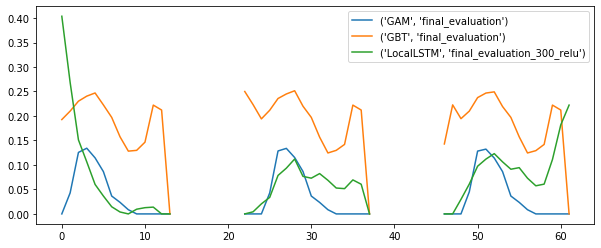

In [333]:
horizon = 64
metric = 'sensitivity'
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_bin.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped[metric].aggregate(np.nanmean).values[-horizon:]
    std = grouped[metric].aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

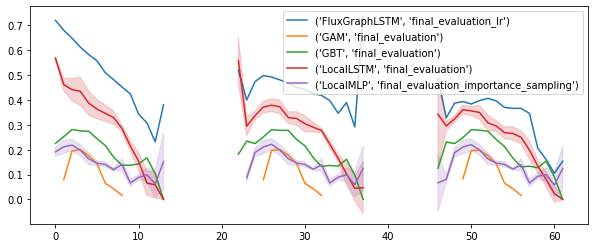

In [35]:
horizon = 64
metric = 'fscore'
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_bin.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped[metric].aggregate(np.nanmean).values[-horizon:]
    std = grouped[metric].aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

In [16]:
b2015 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2015', 'birds_per_seq.npy'))
b2016 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2016', 'birds_per_seq.npy'))
b2017 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2017', 'birds_per_seq.npy'))

idx2015 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2015', 'resampling_idx.npy'))
idx2016 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2016', 'resampling_idx.npy'))
idx2017 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2017', 'resampling_idx.npy'))

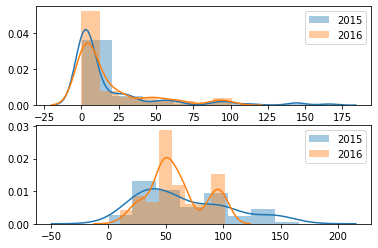

In [167]:
fig, ax = plt.subplots(2, 1)
sb.distplot(b2015, bins=8, ax=ax[0], label='2015')
sb.distplot(b2016, bins=8, ax=ax[0], label='2016')
ax[0].legend()

sb.distplot(b2015[idx2015], bins=8, ax=ax[1], label='2015')
sb.distplot(b2016[idx2016], bins=8, ax=ax[1], label='2016')
ax[1].legend();

In [140]:
b2015.max()

5.841893314617838

28.812529608142828


0.8646647167633873

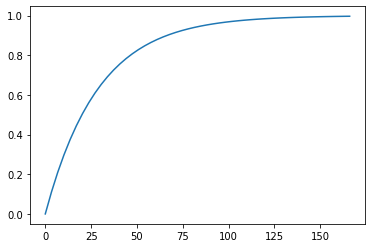

In [228]:
thr = np.quantile(b2015, 0.8)
print(thr)

s = b2015.max()/50
weight_func = lambda x: 1/(1 + np.exp(-(x-thr)/s))
weight_func = lambda x: 1 - np.exp(-x/thr)

xs = np.linspace(0, b2015.max(), 50)
plt.plot(xs, [weight_func(x) for x in xs])
weight_func(2*thr)

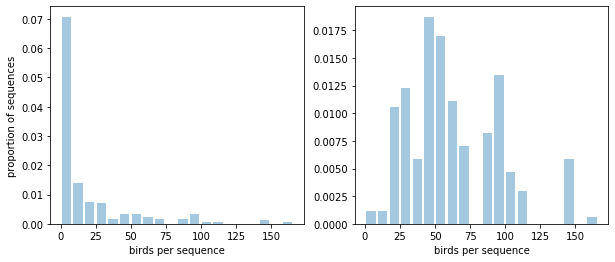

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sb.distplot(np.concatenate([b2015, b2016]), ax=ax[0], bins=20, kde=False, norm_hist=True, hist_kws=dict(rwidth=0.8))
ax[0].set(xlabel='birds per sequence', ylabel='proportion of sequences')

sb.distplot(np.concatenate([b2015[idx2015], b2016[idx2016]]), ax=ax[1], bins=20, kde=False, norm_hist=True, hist_kws=dict(rwidth=0.8))
ax[1].set(xlabel='birds per sequence');
fig.savefig('/home/fiona/birdMigration/data/plots/final/supplementary/importance_sampling.png', bbox_inches='tight', dpi=200)

7.746284886139805


(-0.1, 1.1)

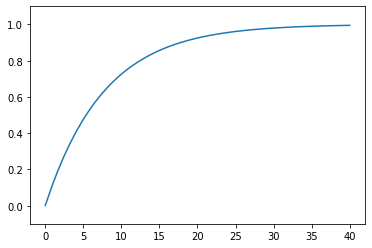

In [307]:
intensity = r['GAM'].groupby('seqID').gt_km2.aggregate(sum).reset_index()
thr = intensity.gt_km2.quantile(0.8)
print(thr)
s = intensity.gt_km2.max()/25
weight_func = lambda x: 1/(1 + np.exp(-(x-thr)/s))
weight_func = lambda x: 1 - np.exp(-x/thr) +0.001
xs = np.linspace(0, 40)
plt.plot(xs, [weight_func(x) for x in xs])
plt.ylim(-0.1,1.1)

In [111]:
idx = np.arange(10) <= 4
np.arange(10)[idx]

array([0, 1, 2, 3, 4])

In [308]:
#weight_func = lambda x: 1/(1 + np.exp(-(x-thr)))
intensity['weight'] = intensity.gt_km2.apply(weight_func)
intensity['weight'] /= intensity['weight'].sum()

In [103]:
intensity = r['GAM'].groupby('seqID').gt_km2.aggregate(sum).reset_index()
intensity['bin'] = pd.cut(intensity.gt_km2, bins=20)
freqs = intensity['bin'].value_counts()
N = freqs.sum()
intensity['weight'] = intensity.bin.apply(lambda x: 1/freqs[x])
intensity['weight'] /= intensity['weight'].sum()

In [309]:
batch = np.random.choice(intensity.gt_km2.values, int(intensity.gt_km2.size*1), p=intensity.weight, replace=True)

In [310]:
index = np.random.choice(np.arange(intensity.gt_km2.size), int(intensity.gt_km2.size*1), p=intensity.weight, replace=True)

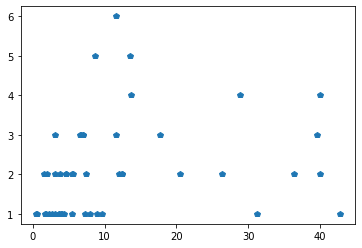

In [311]:
unique, counts = np.unique(index, return_counts=True)
plt.plot(intensity.gt_km2.iloc[unique].values, counts, 'p')
#intensity.gt_km2[~intensity.index.isin(unique)].hist()

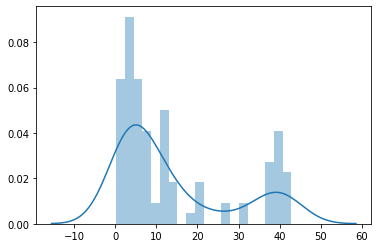

In [312]:
sb.distplot(batch, bins=20)

[Text(0.5, 1.0, '2017-09-13 19:00:00+00:00 - 2017-09-17 10:00:00+00:00')]

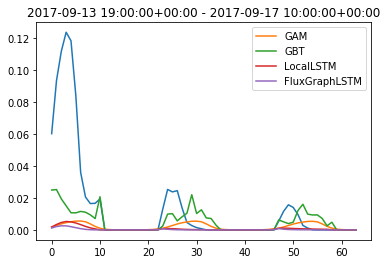

In [84]:
query = 'seqID == 52 & radar == "deess" & trial == 1'
horizon = 64

fig, ax = plt.subplots()

for i, m in enumerate(models.keys()):
    seq = r[m].query(query)
    if i == 0:
        T = seq.gt_km2.size
        ax.plot(range(horizon), seq.gt_km2[-horizon:])
    ax.plot(range(horizon), seq.prediction_km2[-horizon:], label=m)
ax.legend()
ax.set(title=f'{seq.datetime.iloc[0]} - {seq.datetime.iloc[-1]}')

[Text(0.5, 1.0, '2017-10-24 17:00:00+00:00 - 2017-10-28 08:00:00+00:00')]

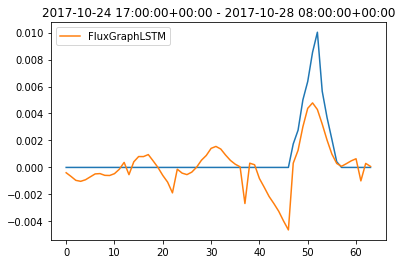

In [50]:
query = 'seqID == 6 & radar == "deess" & trial == 1'
horizon = 64

fig, ax = plt.subplots()

for i, m in enumerate(models.keys()):
    seq = r[m].query(query)
    if i == 0:
        T = seq.gt_km2.size
        ax.plot(range(horizon), seq.gt_km2[-horizon:])
    ax.plot(range(horizon), seq.prediction_km2[-horizon:], label=m)
ax.legend()
ax.set(title=f'{seq.datetime.iloc[0]} - {seq.datetime.iloc[-1]}')

In [68]:
models = {'LocalLSTM': 'final_evaluation_500_decay'}
rseq, _, _, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=False, trials=1)

/home/fiona/birdMigration/results/abm/LocalLSTM/test_2017/final_evaluation_500_decay/trial_1/results_fixedT0.csv
successfully loaded results for LocalLSTM


In [54]:
rseq['LocalLSTM'].radar.unique()

array(['deemd', 'detur', 'denhb', 'deboo', 'deros', 'deisn', 'deess',
       'dehnr', 'nldbl', 'demem', 'deeis', 'bewid', 'deoft', 'bejab',
       'deneu', 'defld', 'bezav', 'depro', 'nldhl', 'defbg', 'dedrs',
       'deumd', 'chalb', 'chwei', 'chlem', 'chppm', 'chdol', 'frmtc',
       'frnan', 'frtro', 'frave', 'frabb', 'frtra', 'frbla', 'frniz',
       'frcae', 'frpla', 'frtre', 'frche', 'frbou', 'frlep', 'frgre',
       'frbor', 'frmom', 'frtou', 'fropo', 'frmcl', 'frnim', 'frbol'],
      dtype=object)

(66,)


[Text(0.5, 1.0, '2017-09-28 18:00:00+00:00 - 2017-10-02 09:00:00+00:00')]

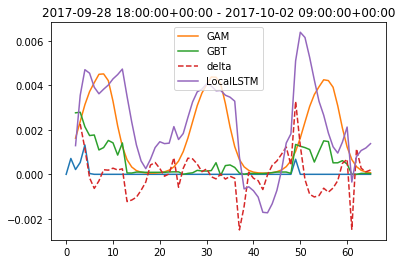

In [218]:
query = 'seqID == 58 & radar == "deumd" & trial == 1'
horizon = 66

fig, ax = plt.subplots()

for i, m in enumerate(models.keys()):
    seq = r[m].query(query)
    if i == 0:
        T = seq.gt_km2.size
        ax.plot(range(horizon), seq.gt_km2[-horizon:])
    if m == 'LocalLSTM':
        delta = seq.prediction_km2[-horizon:].values - seq.prediction_km2[-horizon-1:-1].values
        print(delta.shape)
        ax.plot(range(horizon), delta, label='delta', ls='--')
    ax.plot(range(horizon), seq.prediction_km2[-horizon:], label=m)
ax.legend()
ax.set(title=f'{seq.datetime.iloc[0]} - {seq.datetime.iloc[-1]}')

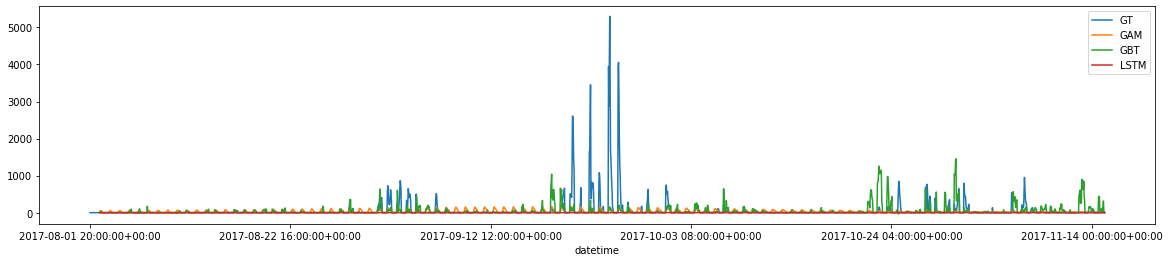

In [101]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'frniz'
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GAM')
r['GBT'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GBT')
r['LocalLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='LSTM')
ax.legend()

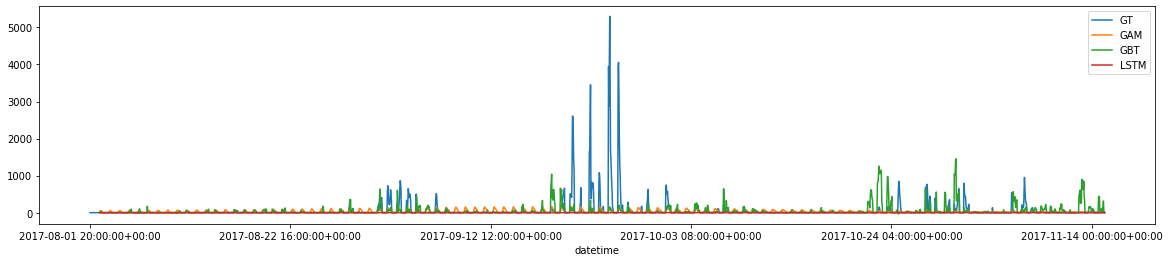

In [85]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'frniz'
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GAM')
r['GBT'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GBT')
r['LocalLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='LSTM')
ax.legend()

In [226]:
r['LocalLSTM'].query(f'radar == "{radar}"').datetime.unique().size

1231

In [227]:
r['GAM'].query(f'radar == "{radar}"').datetime.unique().size

2533

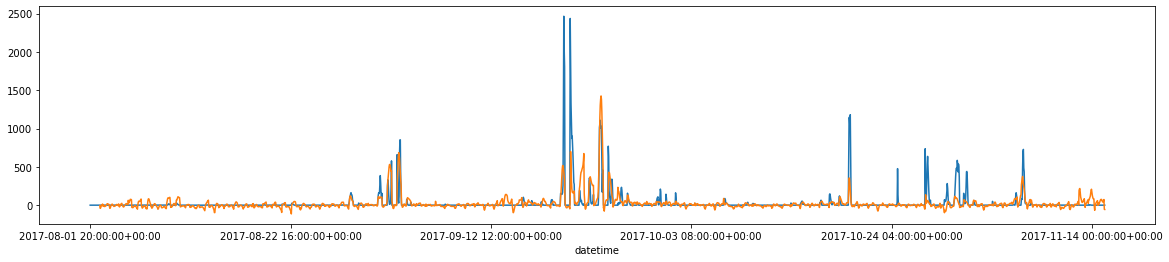

In [65]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='Flux')

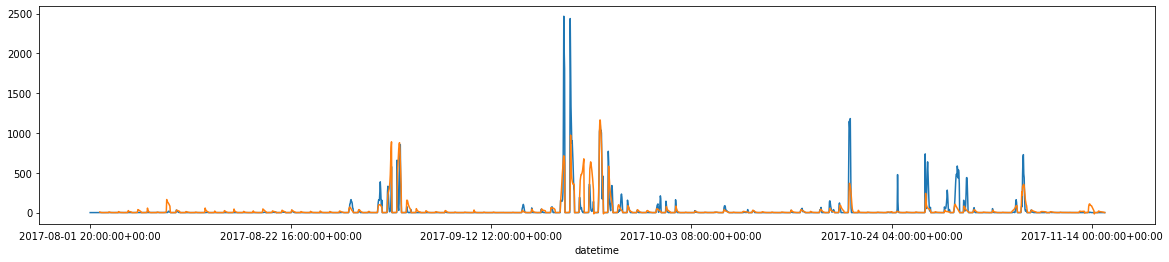

In [71]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='Flux')

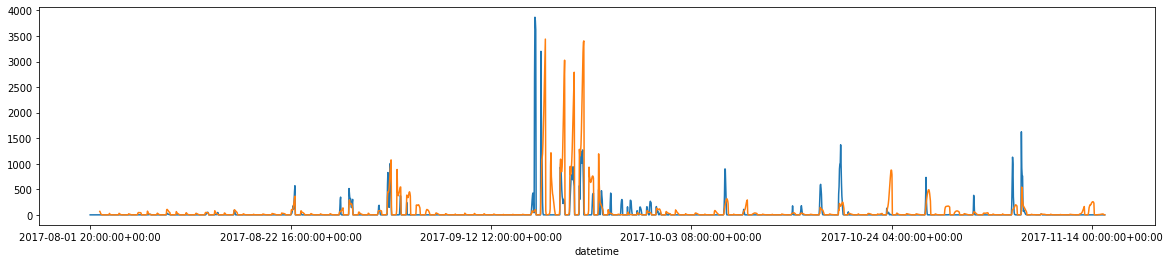

In [40]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'dedrs'
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='Flux')

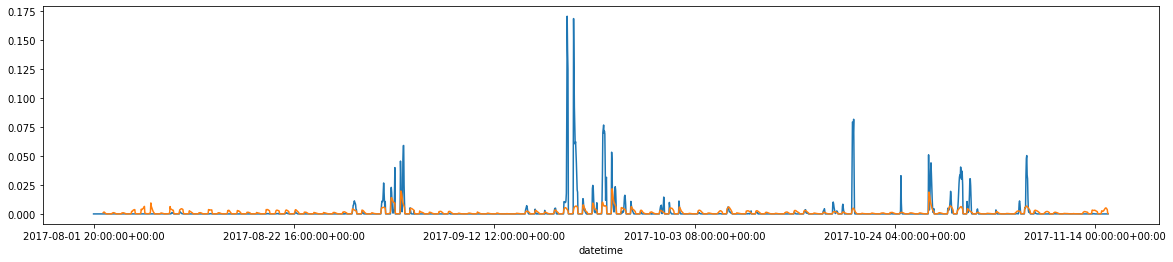

In [86]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['LocalLSTM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['LocalLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='Flux')

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


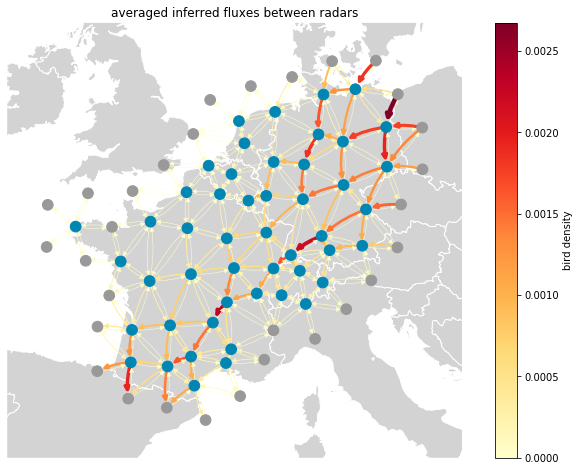

In [110]:
m = 'FluxGraphLSTM'

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=30/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
#ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, fluxes[m][1], r[m], trial=1, 
                         model=0, bird_scale=1,
                        abm=False, ax=ax, crs=crs.proj4_init)

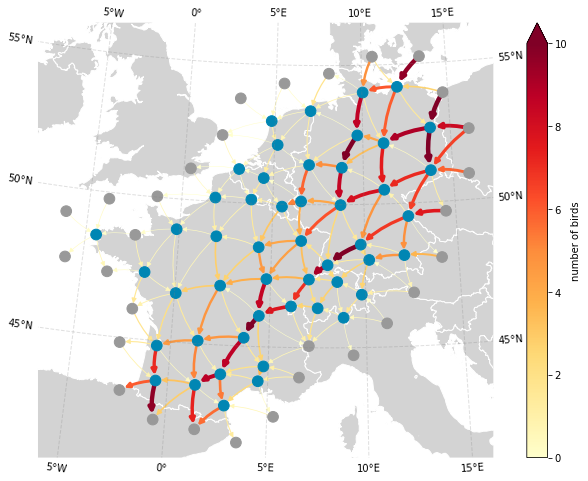

In [130]:
m = 'FluxGraphLSTM'

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=30/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([-6, 16, 41, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_model, ax, max_flux = plot_fluxes(voronoi, G, fluxes[m][1][1], r[m],
                         model=1, bird_scale=5558, max_flux=10,
                        abm=False, ax=ax, crs=crs.proj4_init, net_fluxes=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')

xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_inferred_net_fluxes_map.png'), bbox_inches='tight', dpi=200)

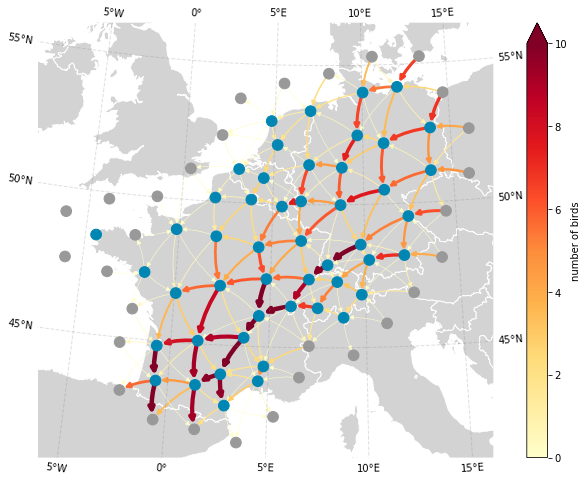

In [132]:
m = 'FluxGraphLSTM'

prep_dir = '/home/fiona/birdMigration/data/preprocessed/1H_voronoi_ndummy=30/abm/fall/2017'
voronoi = gpd.read_file(osp.join(prep_dir, 'voronoi.shp'))
inner_radars = voronoi.query('boundary == False').index.values
G_path = osp.join(prep_dir, 'delaunay.gpickle')
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([-6, 16, 41, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_abm, ax, max_flux = plot_fluxes(voronoi, G, abm_flux_dict, r[m],
                         model=0, bird_scale=1, max_flux=10, net_fluxes=True,
                         ax=ax, crs=crs.proj4_init, cbar=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
xspacing = FixedLocator([-10,-5, 0, 5, 10, 15, 20])
yspacing = FixedLocator([40, 45, 50, 55])
gl.xlocator = xspacing
gl.ylocator = yspacing

fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_simulated_net_fluxes_map.png'), bbox_inches='tight', dpi=200)

In [65]:
cross_edges = 0
cross_birds = 0
total_birds = 0
for n1, n2, d in G_abm.edges(data=True):
    total_birds += d['flux']
    if not (n1, n2) in G_model.edges():
        cross_edges += 1
        cross_birds += d['flux']
print(f'number of cross edges: {cross_edges}')
print(f'number of birds flying between non-adjacent cells: {cross_birds}')
print(f'fraction of birds flying between non-adjacent cells: {cross_birds/total_birds}')


number of cross edges: 26
number of birds flying between non-adjacent cells: 3.374241504854369
fraction of birds flying between non-adjacent cells: 0.005929254659395081


In [44]:
gt_flux.shape
#abm_flux_dict[0].shape
#a = np.fill_diagonal(abm_flux_dict[0][...,0], 0)

(79, 79, 64, 103)

In [46]:
for i in range(gt_flux.shape[0]):
    np.fill_diagonal(gt_flux[i,i], 0)

In [48]:
fluxes[m][1][1][0].shape

torch.Size([79, 79, 64])

In [55]:
idx = voronoi.query('boundary == 1').index.values
gt_flux[idx, idx] = 0

In [63]:
gt_flux.shape

(79, 79, 64, 103)

In [66]:
import itertools as it

In [76]:
for i, j in it.product(idx, repeat=2):
    gt_flux[i, j] = 0

In [40]:
context=24
horizon=64
m = 'FluxGraphLSTM'
gt_flux = torch.stack([f[..., context:context+horizon].sum(-1).fill_diagonal_(0) for f in abm_flux_dict.values()], dim=-1).detach().numpy()
model_flux = torch.stack([f.sum(-1) for f in fluxes[m][1][1].values()], dim=-1).detach().numpy()

In [25]:
i = 3
j = 4
print(gt_flux[i,j, 500:])
print(gt_flux[j,i, 500:])

print(model_flux[i,j, 500:])
print(model_flux[j,i, 500:])

[0. 0. 0. ... 0. 0. 0.]
[78. 99. 77. ...  0.  0.  0.]
[8.44779879e-06 1.36926565e-05 2.25354670e-05 ... 2.79519637e-11
 3.05391185e-10 4.47967774e-10]
[2.7376225e-03 4.2501241e-03 6.1646099e-03 ... 3.3439831e-10 2.8851732e-09
 3.7225751e-09]


In [19]:
voronoi

,radar,observed,x,y,lon,lat,boundary,area_km2,geometry
0,deemd,1,78010.182129,534630.194653,7.025000,53.339440,0,28336.941397,"POLYGON ((8.46942 53.76910, 8.74773 53.31846, ..."
1,detur,1,289641.936092,12574.950682,9.782780,48.585280,0,21947.973094,"POLYGON ((8.23596 48.94716, 10.24674 49.60390,..."
2,denhb,1,49603.953004,174901.219127,6.548530,50.109730,0,17538.033543,"POLYGON ((7.54621 49.41861, 6.29477 49.40976, ..."
3,deboo,1,275109.339319,615784.920502,10.046830,54.004400,0,24051.903586,"POLYGON ((10.93527 54.56347, 11.25814 53.22296..."
4,deros,1,405214.403164,644021.472970,12.058080,54.175660,0,25314.027512,"POLYGON ((10.93527 54.56347, 12.02496 55.01980..."
...,...,...,...,...,...,...,...,...,...
74,boundary_25,0,-363231.827741,-711458.153041,1.474948,42.046999,1,36203.433115,"POLYGON ((1.77664 42.82288, 2.59218 42.10702, ..."
75,boundary_26,0,-531842.620197,-674258.069321,-0.586292,42.277084,1,40669.150366,"POLYGON ((-2.29616 41.83874, -1.26884 42.94127..."
76,boundary_27,0,-667381.875239,-560218.956342,-2.356723,43.184753,1,43815.163480,"POLYGON ((-3.93210 43.88863, -1.79495 44.05632..."
77,boundary_28,0,-666782.812653,-376041.870528,-2.587107,44.830958,1,37137.096556,"POLYGON ((-3.99909 45.73587, -1.63864 45.28824..."


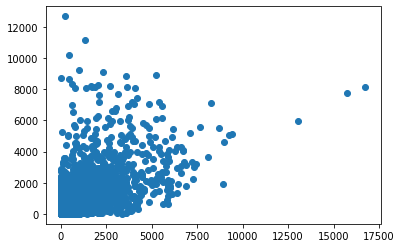

In [46]:
plt.scatter(gt_flux.flatten(), model_flux.flatten()*5558)

[Text(0, 0.5, 'inferred fluxes'), Text(0.5, 0, 'simulated fluxes')]

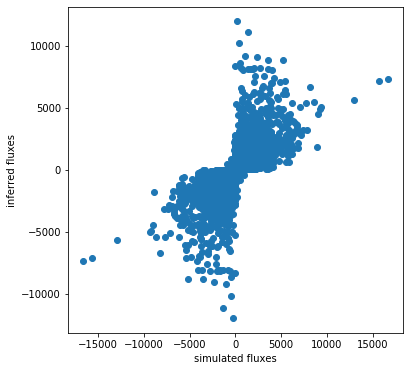

In [47]:
model_net_flux = model_flux - np.moveaxis(model_flux, 0, 1)
gt_net_flux = gt_flux - np.moveaxis(gt_flux, 0, 1)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(gt_net_flux.flatten(), model_net_flux.flatten()*5558)
ax.set(xlabel='simulated fluxes', ylabel='inferred fluxes');

In [50]:
np.corrcoef(gt_net_flux.flatten(), model_net_flux.flatten())

array([[1.        , 0.68558039],
       [0.68558039, 1.        ]])

In [47]:
dep = np.load('/home/fiona/birdMigration/data/raw/abm/departing_birds.npy')
land = np.load('/home/fiona/birdMigration/data/raw/abm/landing_birds.npy')
delta = dep - land

with open('/home/fiona/birdMigration/data/raw/abm/time.pkl', 'rb') as f:
    abm_time = pickle.load(f)
time_dict = {t : idx for idx, t in enumerate(abm_time)}

In [48]:
abm_fluxes = np.load('/home/fiona/birdMigration/data/raw/abm/outfluxes.npy')

In [49]:
abm_flux_dict = {}
for group, df in r['FluxGraphLSTM'].groupby('seqID'):
    time = df.datetime.unique()
    abm_flux_dict[group] = np.stack([abm_fluxes[time_dict[pd.Timestamp(t)]] for t in time], axis=-1)

In [189]:
t = abm_time[10]
time_dict = {t : idx for idx, t in enumerate(abm_time)}
radar_dict = voronoi.radar.to_dict()
radar_dict = {v : k for k, v in radar_dict.items()}

np.where(abm_time == t)[0][0]
time_dict[t]

10

In [190]:
df = r['FluxGraphLSTM'] #.query('missing == 0')
bscale = 5558
def get_abm_delta(datetime, radar):
    tidx = time_dict[pd.Timestamp(datetime)]
    ridx = radar_dict[radar]
    return delta[tidx, ridx] / bscale
    
df['abm_delta'] = df.apply(lambda row: get_abm_delta(row.datetime, row.radar), axis=1)

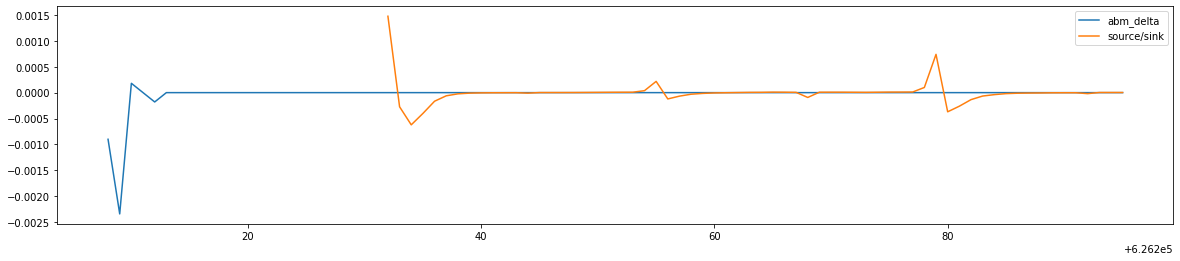

In [157]:
fig, ax = plt.subplots(figsize=(20, 4))
df['abm_delta'] = df['abm_delta']
df.query('seqID == 90 & radar == "deess"')[['abm_delta', 'source/sink']].plot(ax=ax)

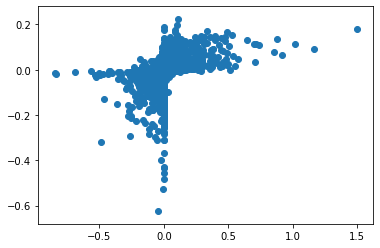

In [226]:
plt.scatter(df.query('horizon < 48').abm_delta.values, df.query('horizon < 48')['source/sink'].values)

In [201]:
inner_radars = voronoi.query('observed == 1').radar.values
#df[df.radar.isin(inner_radars)].groupby('radar')[['abm_delta', 'source/sink']].corr().iloc[0::2,-1]

In [202]:
gr = df[df.radar.isin(inner_radars)].groupby(['seqID', 'radar'])
corr = gr[['abm_delta', 'source/sink']].corr().iloc[0::2,-1].reset_index()

In [203]:
activity = gr['gt'].aggregate(np.nanmean).reset_index()

In [204]:
joint = corr.join(activity, how='outer', rsuffix='_a')

In [202]:
joint2 = joint.query('gt > 10')

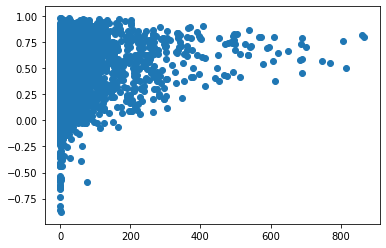

In [192]:
plt.scatter(joint['gt'], joint['source/sink'])

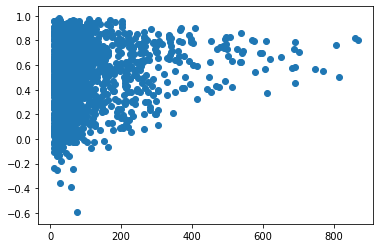

In [203]:
plt.scatter(joint2['gt'], joint2['source/sink'])

In [207]:
joint = joint.query('gt > 0')
joint['gt_bin'] = pd.cut(joint['gt'].values, bins=np.arange(0, 1000, 200))

In [217]:
joint

,seqID,radar,level_2,source/sink,seqID_a,radar_a,gt,gt_bin
3,0,chalb,abm_delta,NaN,0,chalb,2.375000,"(0, 200]"
4,0,chdol,abm_delta,0.503414,0,chdol,1.420455,"(0, 200]"
5,0,chlem,abm_delta,0.043391,0,chlem,0.181818,"(0, 200]"
6,0,chppm,abm_delta,0.189629,0,chppm,1.795455,"(0, 200]"
7,0,chwei,abm_delta,NaN,0,chwei,0.625000,"(0, 200]"
...,...,...,...,...,...,...,...,...
5042,102,frtra,abm_delta,0.850784,102,frtra,1.193182,"(0, 200]"
5043,102,frtre,abm_delta,0.109798,102,frtre,0.852273,"(0, 200]"
5044,102,frtro,abm_delta,0.960202,102,frtro,10.568182,"(0, 200]"
5045,102,nldbl,abm_delta,0.835959,102,nldbl,0.284091,"(0, 200]"


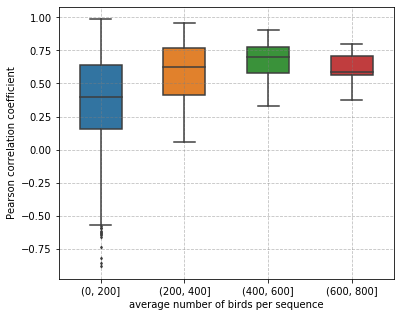

In [210]:
fig, ax = plt.subplots(figsize=(6,5))
sb.boxplot(x='gt_bin', y='source/sink', data=joint, width=0.5, fliersize=2, ax=ax)
#plt.xticks(rotation=45, ha='right')
ax.set(xlabel='average number of birds per sequence', ylabel='Pearson correlation coefficient')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);

fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_source_sink_corr.png'), bbox_inches='tight', dpi=200)

In [236]:
delta_corr = pd.read_csv('/home/fiona/birdMigration/results/abm/FluxGraphLSTM/test_2017/test_new_weight_func_split_delta/performance_evaluation/delta_corr_per_hour.csv')

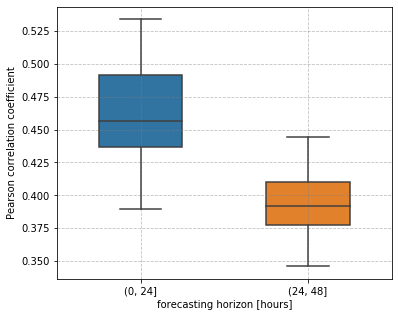

In [237]:
delta_corr['horizon'] = delta_corr['horizon'] - 24
delta_corr.dropna(inplace=True)
delta_corr['bin'] = pd.cut(delta_corr['horizon'], bins=np.arange(0, 64, 24))

fig, ax = plt.subplots(figsize=(6,5))
sb.boxplot(x='bin', y='source/sink', data=delta_corr, width=0.5, fliersize=2, ax=ax)
#plt.xticks(rotation=45, ha='right')
ax.set(xlabel='forecasting horizon [hours]', ylabel='Pearson correlation coefficient')
plt.grid(color = 'gray', linestyle = '--', alpha=0.5);
fig.savefig(osp.join('/home/fiona/birdMigration/data/plots/final', 'abm_source_sink_corr_per_hour_bins.png'), bbox_inches='tight', dpi=200)

In [208]:
gr = df[df.radar.isin(inner_radars)].groupby('radar')
corr = gr[['abm_delta', 'source/sink']].corr().iloc[0::2,-1].reset_index()

In [216]:
corr = corr.join(voronoi, rsuffix='_v')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text xticklabel objects>)

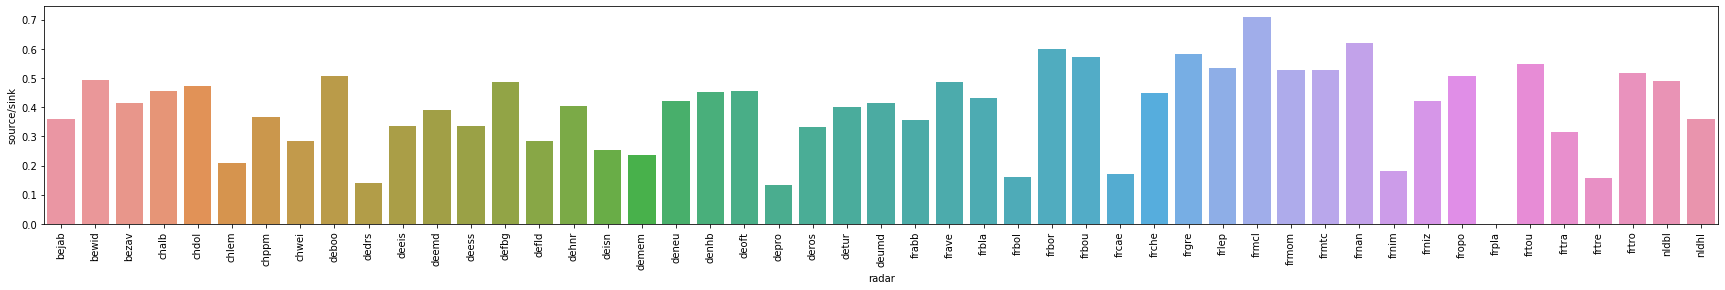

In [223]:
fig, ax = plt.subplots(figsize=(30,4))
sb.barplot(x='radar', y='source/sink', data=corr, ax=ax)
plt.xticks(rotation = 90)